In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
#import pymc as pm
from scipy.integrate import odeint

%matplotlib inline

In [20]:
online = True

if online:
    COVID_CONFIRMED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    COVID_DEATHS_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    COVID_RECOVERED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
else:
    COVID_CONFIRMED_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    COVID_DEATHS_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    COVID_RECOVERED_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
    


covid_confirmed = pd.read_csv(COVID_CONFIRMED_URL)
covid_deaths = pd.read_csv(COVID_DEATHS_URL)
covid_recovered = pd.read_csv(COVID_RECOVERED_URL)

covid_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_deaths.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_recovered.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_confirmed.rename(columns={'Province/State':'State'}, inplace=True)
covid_deaths.rename(columns={'Province/State':'State'}, inplace=True)
covid_recovered.rename(columns={'Province/State':'State'}, inplace=True)


covid_confirmed.head()

,State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,24,40,40,74,84,94,110,110,120,170
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,76,89,104,123,146,174,186,197,212,223
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,139,201,230,264,302,367,409,454,511,584
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,88,113,133,164,188,224,267,308,334,370
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,3,3,3,4,4,5,7,7


In [21]:
Country = 'Russia'
population = {"Russia" : 146745098, "Italy" : 60317000, "China" : 1404328000}

data_Russia_confirmed = covid_confirmed[covid_confirmed.Country == Country].values[0, 4:].astype(int)

data = np.empty((3, data_Russia_confirmed.shape[0]), dtype=np.int64)
data[0] = data_Russia_confirmed

data[1] = covid_deaths   [covid_deaths.Country    == Country].values[0, 4:].astype(int)
data[2] = covid_recovered[covid_recovered.Country == Country].values[0, 4:].astype(int)

data_normed = data.astype(np.float64) / population[Country]
data_normed_only_conf = data_normed[0] - data_normed[1] - data_normed[2]

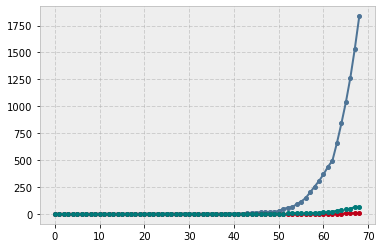

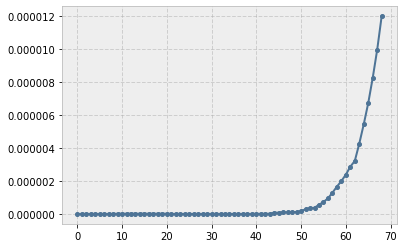

In [22]:
plt.plot(data.T);
plt.figure()
plt.plot(data_normed_only_conf);

In [115]:
@jit
def base_seir_model(init_vals, dt, N, params):
    res = np.empty((N, 4), dtype=np.float64)
    S = res[:, 0]
    E = res[:, 1]
    I = res[:, 2]
    R = res[:, 3]
    S[0], E[0], I[0], R[0] = init_vals
    alpha, beta, gamma = params
    for i in range(1, N):
        S[i] = S[i-1] - (beta*S[i-1]*I[i-1])*dt
        E[i] = E[i-1] + (beta*S[i-1]*I[i-1] - alpha*E[i-1])*dt
        I[i] = I[i-1] + (alpha*E[i-1] - gamma*I[i-1])*dt
        R[i] = R[i-1] + (gamma*I[i-1])*dt

    #print(I)
    return res


def seir_rhs(y, t, alpha, beta, gamma):
    S, E, I, R = y
    return [-beta*S*I, beta*S*I - alpha*E, alpha*E - gamma*I, gamma*I]

def base_seir_model_odeint(init_vals, dt, N, params):
    t_max = N*dt
    t = np.linspace(0, t_max, N + 1)
    sol = odeint(seir_rhs, init_vals, t, args=params)
    #return sol[::int(1/dt)]
    return sol

@jit
def sirx_rhs(x, t, alpha, beta, k0, k):
    S, I, X, R = x
    dsdt = -alpha*S*I - k0*S
    didt = (alpha*S - beta - (k0 + k))*I
    dxdt = (k0 + k)*I
    dRdt = k0*S + beta*I
    return np.array([dsdt, didt, dxdt, dRdt])


def base_sirx_model_rhs(x, params):
    alpha, beta, k0, k = params
    S, I, X, R = x
    dsdt = -alpha*S*I - k0*S
    didt = alpha*S*I - beta*I - k0*I - k*I
    dxdt = (k0+k)*I
    dRdt = k0*S + beta*I
    return np.array([dsdt, didt, dxdt, dRdt])

#@jit
def base_sirx_model_odeint(init_vals, dt, N, params):
    t_max = N*dt
    t = np.linspace(0, t_max, N + 1)
    sol = odeint(sirx_rhs, init_vals, t, args=params)
    #sol[np.isnan(sol)] = 1e20
    #sol[np.isinf(sol)] = 1e20
    return sol



# SIR Model (not working)
@jit
def base_sirf_model(init_vals, dt, N, params):
    res = np.empty((N, 3), dtype=np.float64)
    y = res[:, 0]
    E = res[:, 1]
    I = res[:, 2]
    R = res[:, 3]
    S[0], E[0], I[0], R[0] = init_vals
    alpha, beta, gamma = params
    for i in range(1, N):
        S[i] = S[i-1] - (beta*S[i-1]*I[i-1])*dt
        E[i] = E[i-1] + (beta*S[i-1]*I[i-1] - alpha*E[i-1])*dt
        I[i] = I[i-1] + (alpha*E[i-1] - gamma*I[i-1])*dt
        R[i] = R[i-1] + (gamma*I[i-1])*dt

    return res


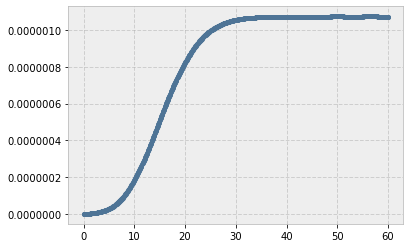

In [6]:
# Test SIRX
t_max = 60
dt = .1
N = int(t_max / dt) + 1
t = np.linspace(0, t_max, N)

x0 = np.array([1.0, 1e-8, 0.0, 0.0])
beta = 0.38 #d^{-1}
R0 = 3.07
alpha = R0*beta
k0 = 6e-2
k = 5e-2

params = alpha, beta, k0, k

results = base_sirx_model_odeint(x0, dt, N, params)

plt.plot(t, results[:, 2]);
#plt.plot(results[:, 1]);

In [142]:
#vals = []

data1 = data[0]
data1 = data1[data1>=3]
data1 = data1/population[Country]
#plt.plot(data1)

#true_cases = data_normed_only_conf[-20:]
#true_cases = data_normed_only_conf[data[0] >= 3]
#true_cases = data_normed[0][data[0] >= 3]
true_cases = data1


def obs(alpha_MC, beta_MC, k0_MC, k_MC, I0_MC, cf = 1, N = len(true_cases), type_ret=2):
        # N is number of points (days)
        #global vals
        dt = 1.0/cf
        num = (N-1)*cf
        res = base_sirx_model_odeint((1.0 - (I0_MC + true_cases[0]), I0_MC, true_cases[0], 0.0), dt, num, (alpha_MC, beta_MC, k0_MC, k_MC))
        rr = res.T[type_ret][::cf]
        #print(rr)
        #vals.append(rr)
        return rr
    

def loss_fn(alpha, beta, k0, k, I0):
#def loss_fn(x):
#    alpha, beta, k0, k, I0 = x
    loss_val = np.linalg.norm( obs(alpha, beta, k0, k, I0) - true_cases )
#    if np.isnan(loss_val) or np.isinf(loss_val):
#        loss_val = 1e100
    return loss_val

_ = """
num_days = len(true_cases)-1
times = np.linspace(0, num_days, num_days+1)

def compute_fit(alpha, beta, k0, k, I0):
    params = np.array([alpha, beta, k0, k])
    x0 = np.array([1.0, I0, true_cases[0], 0.0])
    rhs = lambda x, t: base_sirx_model_rhs(x, params)
    sol = odeint(rhs, x0, times)
    predicted_cases = sol[:, 2]
    return np.linalg.norm(true_cases-predicted_cases)


def predict(alpha, beta, I0, k0, k, num_days):
    times = np.linspace(0, num_days, num_days+1)
    params = np.array([alpha, beta, k0, k])
    x0 = np.array([1.0, I0, true_cases[0], 0.0])
    rhs = lambda x, t: base_sirx_model_rhs(x, params)
    sol = odeint(rhs, x0, times)
    return sol

"""

In [25]:
import nevergrad as ng

In [147]:
def optimize():
    beta0 = 0.38 #d^{-1}
    R0 = 3.07
    alpha0 = R0*beta0
    #k0_0 = 1e-1
    #k_0 = 0.0

    alpha = ng.p.Scalar()
    alpha.value = alpha0
    alpha.value = 0.8921533322357904
    beta = ng.p.Scalar()
    beta.value = beta0
    beta.value = 0.6006857701497142
    I0 = ng.p.Scalar()
    I0.value = 1e-8
    I0.value = 2.0638693642381589e-07
    k0 = ng.p.Scalar()
    k = ng.p.Scalar()
    alpha.set_bounds(0.0, 10.0)
    beta.set_bounds(5e-2, 2.0)
    I0.set_bounds(0.0, 1e-4)
    k0.value = 1e-5
    k.value = 1e-5
    k0.value = 0.003774752347706235
    k.value = 0.018991858675810148
    #k0.set_bounds(0, 5e-2)
    #k.set_bounds(0, 5e-2)
    k0.set_bounds(0, 0.1)
    k.set_bounds(0, 0.1)

    instru = ng.p.Instrumentation(alpha, beta, k0, k, I0)
    optimizer = ng.optimizers.CMA(parametrization=instru, budget=20000, num_workers=6) # num_workers don't work :(
    #optimizer = ng.optimizers.CMA(parametrization=instru, budget=500000)

    recommendation = optimizer.minimize(loss_fn)
    #recommendation = optimizer.minimize(compute_fit)
    return recommendation

max_err = 1e100
for _ in range(30):
    print('.')
    recommendation = optimize()
    err = loss_fn(*recommendation.value[0])
    if err < max_err:
        max_err = err
        vals = recommendation.value[0]
        
max_err, vals
    

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 22:54:30 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/nevergrad/parametrization/data.py:234: UserWarning: Bounds are 1.95 sigma away from each other at the closest, you should aim for at least 3 for better quality.
  warnings.warn(f"Bounds are {min_dist} sigma away from each other at the closest, "
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/nevergrad/parametrization/data.py:234: UserWarning: Bounds are 0.0001 sigma away from each other at the closest, you should aim for at least 3 for better quality.
  warnings.warn(f"Bounds are {min_dist} sigma away from each other at the closest, "
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/nevergrad/parametrization/data.py:234: UserWarning: Bounds are 0.1 sigma away from each other at the closest, you should aim for at least 3 for better quality.
  warnings.warn(f"Bounds are {min_dist} sigma away from each other at the closest, "
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/nevergrad/optimization/base.p

NOTE (module=cma, iteration=848):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 7.1e+07 to 1.4e+05
NOTE (module=cma, iteration=984):  
condition in coordinate system exceeded 1.3e+08, rescaled to 1.0e+00, 
condition changed from 3.3e+08 to 3.3e+06
NOTE (module=cma, iteration=1124):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 4.0e+08 to 2.7e+08
NOTE (module=cma, iteration=1255):  
condition in coordinate system exceeded 1.3e+08, rescaled to 1.0e+00, 
condition changed from 4.2e+10 to 6.0e+10


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1287)
  ')')


NOTE (module=cma, iteration=1727):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 7.2e+12 to 5.8e+12


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.468067e-14.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -3.948339e-15.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.249828e-14.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -5.915147e-13.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.727670e-12.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -5.295659e-13.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -9.262129e-12.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.001585e-11.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -3.325502e-11.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:00:45 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.6e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1116)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0328306856854756) = 2.809006004421921 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=1341)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0510541682228671) = 2.8606651514338504 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=1347)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.1562277586280478) = 3.

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -8.046755e-01.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -5.088717e+00.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.672211e+00.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:04:11 2020)
NOTE (module=cma, iteration=714):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 4.1e+10 to 8.9e+04
NOTE (module=cma, iteration=1739):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 3.0e+08 to 5.5e+01
.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:05:06 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1542)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0980233122157173) = 2.9982335908805737 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=1726)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0085039290286824) = 2.7414964721488224 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=1727)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.1108835481271664) = 3

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:06:03 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=813)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -6.807738e-12.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -7.068514e-12.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.117938e-12.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -4.426315e-13.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -4.225354e-13.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -4.808844e-14.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.522463e-14.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.662122e-14.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:06:57 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1303)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.1069011354106275) = 3.0249698830315874 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=1511)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.187837667749166) = 3.279981124812523 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=1512)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.2336499400371408) = 3.4

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:07:53 2020)
NOTE (module=cma, iteration=779):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 2.2e+08 to 3.0e+02


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1531)
  ')')


.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:08:46 2020)
NOTE (module=cma, iteration=1225):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 6.2e+10 to 3.2e+03


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.8e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1685)
  ')')


.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:09:56 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0784243264695765) = 2.9400433509694266 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=494)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.1716662503129014) = 3.2273657600101324 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=495)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.2244679468790092) = 3.4023553673432163 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=496)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.2539895973323685) = 3.504295835088468 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=497)
  ')')
/home/gleb/anaconda2/envs/py3

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:10:51 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.040544310027758) = 2.8307574047301083 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=733)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.1502438610291141) = 3.1589631637765256 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=734)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.2123614506322635) = 3.3614130986347015 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=735)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.1746094494291217) = 3.236878532187077 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=736)
  ')')
/home/gleb/anaconda2/envs/py3/

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:18:31 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0817589122159865) = 2.94986354165574 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=1418)
  ')')


NOTE (module=cma, iteration=1761):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 2.7e+08 to 4.6e+02


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0106511060199737) = 2.7473892744763133 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=2495)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.12339515731301) = 3.075277549892767 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=2496)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0301271730394872) = 2.8014220774068352 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=2497)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.1439226947596564) = 3.139057811180947 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=2498)
  ')')


.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:23:40 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=713)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.264222e-04.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.075072e-04.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.781635e-01.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.562848e-01.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.491141e-01.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:25:28 2020)
NOTE (module=cma, iteration=1129):  
condition in coordinate system exceeded 1.2e+08, rescaled to 1.0e+00, 
condition changed from 2.8e+08 to 2.6e+04


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0611326533249839) = 2.889642099133112 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=1393)
  ')')


NOTE (module=cma, iteration=2061):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 2.7e+09 to 1.4e+03
NOTE (module=cma, iteration=2346):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 5.5e+11 to 1.2e+04
NOTE (module=cma, iteration=2459):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 2.1e+09 to 2.3e+02
.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:26:27 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.012657742119645) = 2.7529078199788963 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=512)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.3e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=980)
  ')')


.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:27:26 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1906)
  ')')


.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:28:40 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.4e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1114)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.073631e-10.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -9.449552e-10.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -4.666991e-08.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.903235e-07.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -5.177079e-08.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.868349e-05.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.208666e-04.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.235542e-04.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -3.257549e-04.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -3.229526e-04.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -4.853455e-04.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.590581e-02.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.590643e-02.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.586111e-02.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -7.211751e-02.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -8.805657e-01.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -3.901295e+00.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.444800e+01.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.283271e+01.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.129655e+01.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -5.936849e+02.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.658478e+04.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.649971e+04.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.196830e+05.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -7.706066e+03.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -6.435416e+03.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:29:38 2020)
NOTE (module=cma, iteration=621):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.7e+09 to 3.6e+05


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0137083725778466) = 2.7558016286787796 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=693)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.1308866435866) = 3.098402461271392 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=694)
  ')')


.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:30:36 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.036388559252082) = 2.8190178925883638 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=365)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.1430922652975952) = 3.1364521271595622 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=366)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.2033740704544706) = 3.331338151112973 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=367)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.2210779180848839) = 3.390840813042777 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=368)
  ')')
/home/gleb/anaconda2/envs/py3/l

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:31:33 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.024041565913866) = 2.7844254929734946 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=621)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.3e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1841)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -3.693730e-08.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWar

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:32:55 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=869)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.1130439538394432) = 3.043608913254127 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=952)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.1930164917160486) = 3.2970116306049353 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=953)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.1801246360785993) = 3.254

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:35:22 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.8e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1127)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0513323174255844) = 2.861460953835734 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=1244)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.066244e-06.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWa

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.285519e-08.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.916318e-09.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.033197838462656) = 2.81003752812937 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=2422)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0310596984262155) = 2.804035693055029 clipped to

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:36:18 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.6e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=2268)
  ')')


.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:37:58 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0234380027894985) = 2.7827454234883837 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=424)
  ')')


NOTE (module=cma, iteration=986):  
condition in coordinate system exceeded 1.5e+08, rescaled to 1.0e+00, 
condition changed from 1.9e+11 to 3.2e+06
.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:40:03 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=2112)
  ')')


.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:41:01 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.035824330578795) = 2.817427770501279 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=467)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=595)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0045104888224656) = 2.7305703009379303 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=931)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0847559667047555) = 2.9587

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:42:02 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0599983219469933) = 2.886366145788505 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=611)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.159250530400174) = 3.187543413776714 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=612)
  ')')


NOTE (module=cma, iteration=2023):  
condition in coordinate system exceeded 1.2e+08, rescaled to 1.0e+00, 
condition changed from 1.0e+08 to 5.0e+01
NOTE (module=cma, iteration=2228):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 3.0e+09 to 6.2e+02


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.3e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=2376)
  ')')


.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:50:58 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=620)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0427971945243382) = 2.8371419633369594 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=864)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.1161735248230378) = 3.0531490238345937 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=865)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.1149172750286382) = 3.04

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -5.579814e-11.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.777747e-12.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -9.647882e-11.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.339739e-08.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.247955e-08.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.834687e-07.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -7.097548e-09.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.441201e-08.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.392978e-08.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.455451e-07.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.426763e-07.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -4.596994e-08.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -3.033545e-05.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -7.529666e-06.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -8.846857e-08.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:53:23 2020)
NOTE (module=cma, iteration=1131):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 2.6e+09 to 8.1e+05
NOTE (module=cma, iteration=1370):  
condition in coordinate system exceeded 1.2e+08, rescaled to 1.0e+00, 
condition changed from 3.8e+09 to 3.5e+09
NOTE (module=cma, iteration=1603):  
condition in coordinate system exceeded 1.2e+08, rescaled to 1.0e+00, 
condition changed from 1.9e+11 to 2.4e+11


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1694)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0962694341584924) = 2.9929796634958667 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=1784)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.1816501301257873) = 3.2597487769561857 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=1785)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.230000872863739) = 3.

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:56:46 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=787)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.125893238154292) = 3.08296944531002 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=2348)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0889981688263917) = 2.971295844168436 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=2350)
  ')')


.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 23:57:42 2020)
NOTE (module=cma, iteration=1111):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 1.2e+09 to 7.2e+03


(5.102635615002584e-07,
 (1.4394662389490493,
  1.1010126012811137,
  0.0022895913314954675,
  0.06789202922579622,
  6.695856539796995e-08))

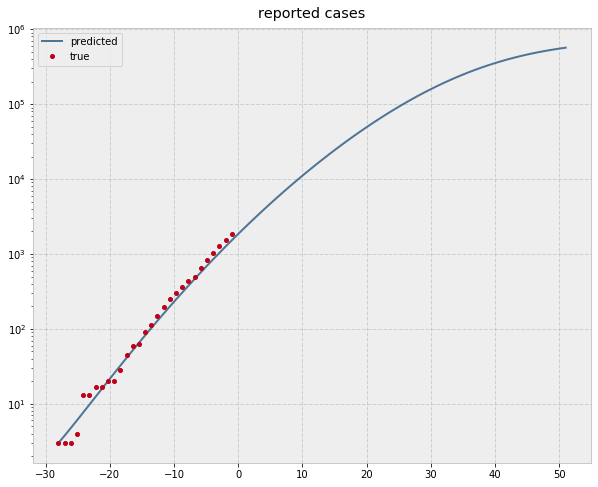

In [149]:
num_days = 80
time_scale = np.linspace(-len(true_cases)+1, num_days - len(true_cases), num_days)
time_scale_true = np.linspace(-len(true_cases)+1 , -1, len(true_cases))
plt.figure(figsize=(10, 8))
vals = (1.2173437044675621,
  0.9855553151918058,
  0.0,
  0.00022902367817583327,
  2.7873569184833206e-05)
alpha_g, beta_g, k0_g, k_g, I0_g = vals
plt.plot(time_scale, population[Country]*obs(alpha_g, beta_g, k0_g, k_g, I0_g, N=num_days, cf=1), "-", label="predicted");
plt.plot(time_scale_true, population[Country]*true_cases, "o", label="true");
plt.legend();
plt.title('reported cases');
plt.yscale('log')

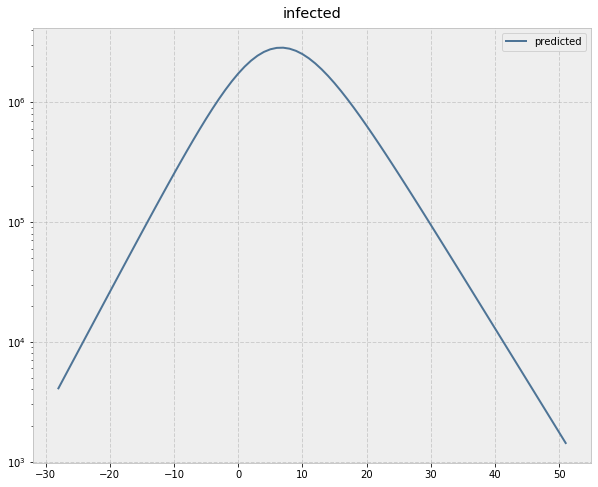

In [145]:
plt.figure(figsize=(10, 8))
vals = (1.2173437044675621,
  0.9855553151918058,
  0.0,
  0.00022902367817583327,
  2.7873569184833206e-05)
alpha_g, beta_g, k0_g, k_g, I0_g = vals
plt.plot(time_scale, population[Country]*obs(alpha_g, beta_g, k0_g, k_g, I0_g, N=80, type_ret=1), "-", label="predicted");
plt.legend();
plt.title('infected');
plt.yscale('log');

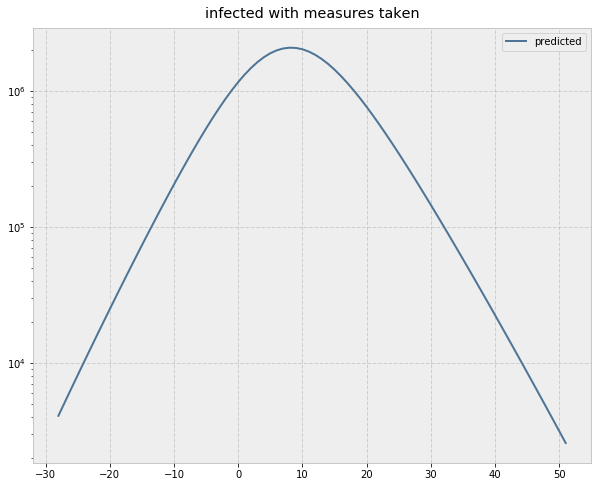

In [146]:
plt.figure(figsize=(10, 8))

vals = (1.2173437044675621,
  0.9855553151918058,
  1e-3,
  0.00022902367817583327,
  2.7873569184833206e-05)
alpha_g, beta_g, k0_g, k_g, I0_g = vals

plt.plot(time_scale, population[Country]*obs(alpha_g, beta_g, k0_g, k_g, I0_g, N=80, type_ret=1), "-", label="predicted");
plt.legend();
plt.title('infected with measures taken');
plt.yscale('log');

In [70]:
recommendation.value[0]

(1.4620735715158846,
 1.1550524698389562,
 0.00012016896136317736,
 0.09431369871672939,
 8.85266762057214e-08)

In [67]:
good_vals_1 = (0.8921533322357904,
 0.6006857701497142,
 0.003774752347706235,
 0.018991858675810148,
 2.0638693642381589e-07)

good_vals_2 = (1.4620735715158846,
 1.1550524698389562,
 0.00012016896136317736,
 0.09431369871672939,
 8.85266762057214e-08)


In [ ]:
(0.7028386750218786, 0.5248873953209352, 0.0026616813473804538, 0.0, 1e-05)

In [69]:
loss_fn(*good_vals_1), loss_fn(*recommendation.value[0])

(2.938729818873531e-06, 5.876705339440785e-07)

In [62]:
print(sorted(ng.optimizers.registry.keys()))

['ASCMA2PDEthird', 'ASCMADEQRthird', 'ASCMADEthird', 'AlmostRotationInvariantDE', 'BO', 'CM', 'CMA', 'CMandAS', 'CMandAS2', 'CMandAS3', 'CauchyLHSSearch', 'CauchyOnePlusOne', 'CauchyScrHammersleySearch', 'Cobyla', 'DE', 'DiagonalCMA', 'DiscreteOnePlusOne', 'DoubleFastGADiscreteOnePlusOne', 'EDA', 'ES', 'FCMA', 'HaltonSearch', 'HaltonSearchPlusMiddlePoint', 'HammersleySearch', 'HammersleySearchPlusMiddlePoint', 'LHSSearch', 'LargeHaltonSearch', 'LhsDE', 'MEDA', 'MPCEDA', 'MetaRecentering', 'MixES', 'MultiCMA', 'MultiScaleCMA', 'MutDE', 'NGO', 'NaiveIsoEMNA', 'NaiveTBPSA', 'NelderMead', 'NoisyBandit', 'NoisyDE', 'NoisyDiscreteOnePlusOne', 'NoisyOnePlusOne', 'ORandomSearch', 'OScrHammersleySearch', 'OnePlusOne', 'OptimisticDiscreteOnePlusOne', 'OptimisticNoisyOnePlusOne', 'PBIL', 'PCEDA', 'PSO', 'ParaPortfolio', 'Portfolio', 'Powell', 'QORandomSearch', 'QOScrHammersleySearch', 'QrDE', 'RCobyla', 'RPowell', 'RSQP', 'RandomSearch', 'RandomSearchPlusMiddlePoint', 'RealSpacePSO', 'RecES', 'Re

In [138]:
cf = 4
N = 9
dt = 1.0/cf
num = (N-1)*cf
t_max = (num)*dt
t = np.linspace(0, t_max, num+1)
t

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25,
       4.5 , 4.75, 5.  , 5.25, 5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  , 7.25, 7.5 , 7.75, 8.  ])

In [139]:
t[::cf]

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])